## QPE parsed_counts and histogram functions

Note for syralie: try "ipython kernel install --user --name=qcourse" after activating venv if needed

In [1]:
import classiq

classiq.authenticate() #overwrite=True

The current version of 'classiq' has been deprecated, and will not be supported as of 2024-02-15. Please run "pip install -U classiq" to upgrade the classiq SDK to the latest version.
/Users/syralie/Desktop/QCourse551-1/qcourse/lib/python3.11/site-packages/classiq/_internals/authentication/token_manager.py:82: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [2]:
import numpy as np
from math import pi, sqrt

from classiq.builtin_functions.exponentiation import PauliOperator
from classiq.builtin_functions import Exponentiation, PhaseEstimation, XGate, UnitaryGate, PhaseGate
from classiq import Model, synthesize, show, execute, set_execution_preferences, set_quantum_program_execution_preferences, GeneratedCircuit
from classiq.execution import ExecutionPreferences
from classiq.builtin_functions import IGate, HGate

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import csv
import json


In [3]:
def Curve_Fitted_QPE(quantum_program):

    def fitting_curve_parameters(recording_qubits, data_y, data_prob, y_guess, curve_plot=True):
        
        M = 2 ** recording_qubits
        
        def prob_func(y, theta):
            angle = y - (theta * M) 
            numerator = 1 - np.cos(2 * pi * angle)
            denominator = 1 - np.cos(2 * pi * angle / M)
            coeff = 1 / (M**2)
            prob_y = coeff * numerator/denominator
            prob_y  = np.nan_to_num(prob_y , nan=(1 / (M**2)))
            return prob_y
        
        guess1 = (y_guess - 0.5)/M
        guess2 = (y_guess + 0.5)/M
        bounds = (guess1, guess2)
    
        try: 
            parameters1, pcov1 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess1) 
        except ValueError:
            pcov1 = np.inf
        
        try:
            parameters2, pcov2 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess2)
        except ValueError:
            pcov2 = np.inf
            
        parameters_list = [parameters1, parameters2]
        pcov_list = [pcov1, pcov2]

        if np.isinf(pcov1) and np.isinf(pcov2):
            print("No optimal parameters found")
            return False, False
        else:
            index = pcov_list.index(min(pcov_list))
            parameters = parameters_list[index]
            pcov = pcov_list[index]

        range_y = np.linspace(0, M, 1000)
        probabilities = np.array(prob_func(range_y, parameters[0]))
        if curve_plot == True:
            plt.plot(range_y, probabilities)
        return parameters, pcov
    

    def get_counts(quantum_program):
        job = execute(quantum_program)
        results = job.result()
        return results[0].value.counts, results[0].value.parsed_counts

    def process_parsed_counts(parsed_counts):
        y = []
        shots = []
        for item in parsed_counts:
            y.append(item.state['Phase'])
            shots.append(item.shots)
        return np.array(y), np.array(shots)

    recording_qubits = GeneratedCircuit.parse_raw(quantum_program).model.functions[0].body[1].function_params.size
    num_shots = GeneratedCircuit.parse_raw(quantum_program).model.execution_preferences.num_shots
    
    _, parsed_counts = get_counts(quantum_program)
    y, shots = process_parsed_counts(parsed_counts)
    y_guess = y[:1]
    prob = (1/num_shots) * np.array(shots)
    parameters, _ = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess, curve_plot=False)
    if parameters == False:
        return False
    else:
        return parameters[0]

### Old drafts/work

In [17]:
def two_maxima_parameters(recording_qubits, data_y, data_prob, guesses, bounds = (0, 1)):
    
    M = 2 ** recording_qubits
    
    def prob_func(y, theta0, theta1):
        coeff = 1 / (M**2)
        
        a0 = 0.5
        a1 = 0.5

        angle0 = y - (theta0 * M)
        numerator0 = 1 - np.cos(2 * pi * angle0)
        denominator0 = 1 - np.cos(2 * pi * angle0 / M)

        angle1 = y - (theta1 * M)
        numerator1 = 1 - np.cos(2 * pi * angle1)
        denominator1 = 1 - np.cos(2 * pi * angle1 / M)
        
        prob_y = coeff * (a0 * numerator0/denominator0 + a1 * numerator1/denominator1)
        return prob_y
    
    guess1 = [(guesses[0] - 0.5)/M, (guesses[1] - 0.5)/M]
    guess2 = [(guesses[0] + 0.5)/M, (guesses[1] + 0.5)/M]
    guess3 = [(guesses[0] - 0.5)/M, (guesses[1] + 0.5)/M]
    guess4 = [(guesses[0] + 0.5)/M, (guesses[1] - 0.5)/M]

    bounds = ([(guesses[0] - 0.5)/M , (guesses[1] - 0.5)/M], [(guesses[0] + 0.5)/M, (guesses[1] + 0.5)/M])
    
    try: 
        parameters1, pcov1 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess1) # max_nfev = 1000
    except ValueError:
        pcov1 = np.inf
    
    try:
        parameters2, pcov2 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess2)
    except ValueError:
        pcov2 = np.inf
    
    try:
        parameters3, pcov3 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess3)
    except ValueError:
        pcov3 = np.inf
    
    try:
        parameters4, pcov4 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess4)
    except ValueError:
        pcov4 = np.inf


    parameters_list = [parameters1, parameters2, parameters3, parameters4]
    pcov_sum_list = [np.sum(pcov1), np.sum(pcov2), np.sum(pcov3), np.sum(pcov4)]
    pcov_list = [pcov1, pcov2, pcov3, pcov4]

    if np.isinf(pcov_sum_list[0]) and np.isinf(pcov_sum_list[1]) and np.isinf(pcov_sum_list[2]) and np.isinf(pcov_sum_list[3]):
        print("No optimal parameters found")
        return False, False
    else:
        index = pcov_sum_list.index(min(pcov_sum_list))
        parameters = parameters_list[index]
        pcov = pcov_list[index]

    range_y = np.linspace(0, M, 1000)
    probabilities = np.array(prob_func(range_y, parameters[0], parameters[1]))
    #probabilities = np.nan_to_num(probabilities, nan=1 / (M**2))
    plt.plot(range_y, probabilities)
    return parameters, pcov

In [9]:
def synthesize_from_phase(theta, recording_qubits=3, raw=False, num_shots=2048):
    model = Model()
    
    x_qpe = model.XGate(params=XGate())
    qpe_out = model.PhaseEstimation(
        params=PhaseEstimation(
            size=recording_qubits,
            unitary_params=PhaseGate(theta=theta)
        ),
        in_wires={"TARGET": x_qpe["TARGET"]},
    )
    
    if raw == False:
        model.set_outputs(
            {
                "Phase": qpe_out["PHASE_ESTIMATION"],
                # "Target": qpe_out["TARGET"]
            }
        )
    
    execution_preferences = ExecutionPreferences(
        num_shots=num_shots
    )  
    
    model.execution_preferences = execution_preferences
    quantum_program = synthesize(model.get_model())
    return quantum_program


def synthesize_from_pauli(pauli_list, recording_qubits=3, raw=False, num_shots=2048):
    model = Model()

    x_qpe = model.XGate(params=XGate())
    qpe_out = model.PhaseEstimation(
        params=PhaseEstimation(
            size=recording_qubits,
            unitary_params=Exponentiation(
                pauli_operator=PauliOperator(
                    pauli_list=pauli_list
                ),
                evolution_coefficient=-2 * pi,
            ),
        ),
        in_wires={"IN[0]": x_qpe["TARGET"]},
    )

    if raw == False:
        model.set_outputs(
            {
                "Phase": qpe_out["PHASE_ESTIMATION"],
                # "Target": qpe_out["TARGET"]
            }
        )
    
    execution_preferences = ExecutionPreferences(
        num_shots=num_shots
    )  

    model.execution_preferences = execution_preferences
    quantum_program = synthesize(model.get_model())
    return quantum_program


def synthesize_from_matrix(matrix, recording_qubits=3, raw=False, num_shots=2048):
    model = Model()
    
    h_qpe = model.HGate(params=HGate())
    qpe_out = model.PhaseEstimation(
        params=PhaseEstimation(
            size=recording_qubits,
            unitary_params=UnitaryGate(data=matrix)
        ),
        in_wires={"TARGET": h_qpe["TARGET"]},
        # in_wires={"TARGET[0]": h_qpe["TARGET"], "TARGET[1]": h_qpe1["TARGET"]},
    )
    
    if raw == False:
        model.set_outputs(
            {
                "Phase": qpe_out["PHASE_ESTIMATION"],
                # "Target": qpe_out["TARGET"]
            }
        )
    
    execution_preferences = ExecutionPreferences(
        num_shots=num_shots
    ) 
    
    model.execution_preferences = execution_preferences
    quantum_program = synthesize(model.get_model())
    return quantum_program

In [10]:


def get_counts(quantum_program):
    job = execute(quantum_program) #job is like an id, can be used later
    results = job.result()
    return results[0].value.counts, results[0].value.parsed_counts

def process_parsed_counts(parsed_counts):
    y = []
    shots = []
    for item in parsed_counts:
        y.append(item.state['Phase'])
        shots.append(item.shots)
    return np.array(y), np.array(shots)

    
def generate_histogram(y, prob, figsize=(10, 5)):
    fig = plt.figure(figsize = figsize)

    plt.scatter(y, prob)

In [11]:


def fitting_curve_parameters(recording_qubits, data_y, data_prob, y_guess, curve_plot=True):
    
    M = 2 ** recording_qubits
    
    def prob_func(y, theta):
        angle = y - (theta * M) 
        numerator = 1 - np.cos(2 * pi * angle)
        denominator = 1 - np.cos(2 * pi * angle / M)
        coeff = 1 / (M**2)
        prob_y = coeff * numerator/denominator
        prob_y  = np.nan_to_num(prob_y , nan=(1 / (M**2)))
        return prob_y
    
    guess1 = (y_guess - 0.5)/M
    guess2 = (y_guess + 0.5)/M
    bounds = (guess1, guess2)
    
    try: 
        parameters1, pcov1 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess1) # max_nfev = 1000
    except ValueError:
        pcov1 = np.inf
    
    try:
        parameters2, pcov2 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess2)
    except ValueError:
        pcov2 = np.inf
    parameters_list = [parameters1, parameters2]
    pcov_list = [pcov1, pcov2]

    if np.isinf(pcov1) and np.isinf(pcov2):
        print("No optimal parameters found")
        return False, False
    else:
        index = pcov_list.index(min(pcov_list))
        parameters = parameters_list[index]
        pcov = pcov_list[index]

    range_y = np.linspace(0, M, 1000)
    probabilities = np.array(prob_func(range_y, parameters[0]))
    #probabilities = np.nan_to_num(probabilities, nan=1 / (M**2))
    if curve_plot == True:
        plt.plot(range_y, probabilities)
    return parameters, pcov
    


In [12]:
def multiple_fitting_curve_parameters(recording_qubits, data_y, data_prob, guesses, bounds = (0, 1)):
    
    M = 2 ** recording_qubits
    
    def prob_func(y, a0, a1, theta0, theta1):
        coeff = 1 / (M**2)
        
        angle0 = y - (theta0 * M)
        numerator0 = 1 - np.cos(2 * pi * angle0)
        denominator0 = 1 - np.cos(2 * pi * angle0 / M)

        angle1 = y - (theta1 * M)
        numerator1 = 1 - np.cos(2 * pi * angle1)
        denominator1 = 1 - np.cos(2 * pi * angle1 / M)
        
        prob_y = coeff * (a0 * numerator0/denominator0 + a1 * numerator1/denominator1)
        return prob_y
    
    guess1 = [0.5, 0.5, (guesses[0] - 0.5)/M, (guesses[1] - 0.5)/M]
    guess2 = [0.5, 0.5, (guesses[0] + 0.5)/M, (guesses[1] + 0.5)/M]
    guess3 = [0.5, 0.5, (guesses[0] - 0.5)/M, (guesses[1] + 0.5)/M]
    guess4 = [0.5, 0.5, (guesses[0] + 0.5)/M, (guesses[1] - 0.5)/M]

    bounds = ([0, 0,(guesses[0] - 0.5)/M , (guesses[1] - 0.5)/M], [1, 1, (guesses[0] + 0.5)/M, (guesses[1] + 0.5)/M])
    
    try: 
        parameters1, pcov1 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess1) # max_nfev = 1000
    except ValueError:
        pcov1 = np.inf
    
    try:
        parameters2, pcov2 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess2)
    except ValueError:
        pcov2 = np.inf
    
    try:
        parameters3, pcov3 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess3)
    except ValueError:
        pcov3 = np.inf
    
    try:
        parameters4, pcov4 = curve_fit(prob_func, data_y, data_prob, bounds = bounds, p0 = guess4)
    except ValueError:
        pcov4 = np.inf


    parameters_list = [parameters1, parameters2, parameters3, parameters4]
    pcov_sum_list = [np.sum(pcov1), np.sum(pcov2), np.sum(pcov3), np.sum(pcov4)]
    pcov_list = [pcov1, pcov2, pcov3, pcov4]

    if np.isinf(pcov_sum_list[0]) and np.isinf(pcov_sum_list[1]) and np.isinf(pcov_sum_list[2]) and np.isinf(pcov_sum_list[3]):
        print("No optimal parameters found")
        return False, False
    else:
        index = pcov_sum_list.index(min(pcov_sum_list))
        parameters = parameters_list[index]
        pcov = pcov_list[index]

    range_y = np.linspace(0, M, 1000)
    probabilities = np.array(prob_func(range_y, parameters[0], parameters[1], parameters[2], parameters[3]))
    #probabilities = np.nan_to_num(probabilities, nan=1 / (M**2))
    plt.plot(range_y, probabilities)
    return parameters, pcov

The initial y guesses are  [4. 3.] and the approximate values should be 4.0  and  2.6666666666666665
The guessed values are:  [0.48856244 0.33342832] with covariance:  [[5.11421482e-07 4.70515544e-08]
 [4.70515544e-08 5.49627953e-08]]
The actual thetas are  0.5  and  0.3333333333333333


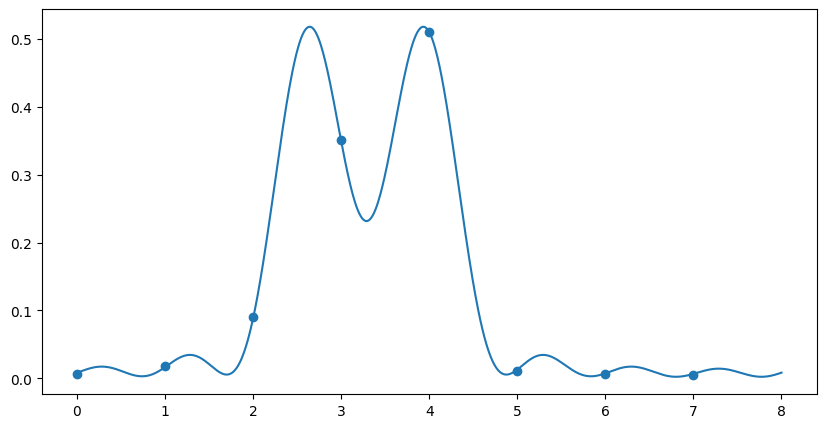

In [18]:
theta1 = 1/2
theta2 = 1/3
recording_qubits = 3
total_shots = 2048
matrix = [[np.exp(1j * 2*pi * theta1), 0],
          [0, np.exp(1j * 2*pi * theta2)]]
counts, parsed_counts = get_counts(synthesize_from_matrix(matrix=matrix, recording_qubits=recording_qubits))
y, shots = process_parsed_counts(parsed_counts)
prob = (1/total_shots) * np.array(shots)
generate_histogram(y, prob)
guesses = y[:2]
print("The initial y guesses are ", guesses, "and the approximate values should be", theta1*(2**recording_qubits), " and ", theta2*(2**recording_qubits))
parameters, pcov = two_maxima_parameters(recording_qubits, y, prob, guesses = guesses)
print("The guessed values are: ", parameters, "with covariance: ", pcov) #parameters consists of [a0, a1, theta0, theta1]
print("The actual thetas are ", theta1, " and ", theta2)

In [ ]:
def Curve_Fitted_QPE_test(quantum_program):

    recording_qubits = GeneratedCircuit.parse_raw(quantum_program).model.functions[0].body[1].function_params.size
    num_shots = GeneratedCircuit.parse_raw(quantum_program).model.execution_preferences.num_shots
    
    _, parsed_counts = get_counts(quantum_program)
    y, shots = process_parsed_counts(parsed_counts)
    y_guess = y[:1]
    prob = (1/num_shots) * np.array(shots)
    parameters, _ = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess, curve_plot=False)
    if parameters == False:
        print("No parameters found")
        return False
    else:
        return parameters[0]

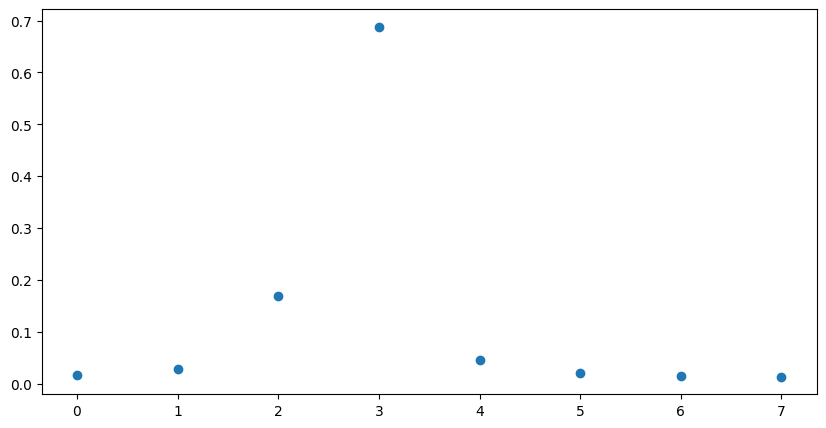

In [ ]:
recording_qubits = 3
total_shots = 2048
counts, parsed_counts = get_counts(synthesize_from_phase(theta = 2*pi/3, recording_qubits=recording_qubits))
y, shots = process_parsed_counts(parsed_counts)
y_guess = y[np.where(shots == max(shots))][0]
y_guess = np.sum(y * shots)/total_shots
prob = (1/total_shots) * np.array(shots)
generate_histogram(y, prob)
#parameters, pcov = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess)
#print(parameters, pcov)

[0.33241183] [[2.65705916e-08]]


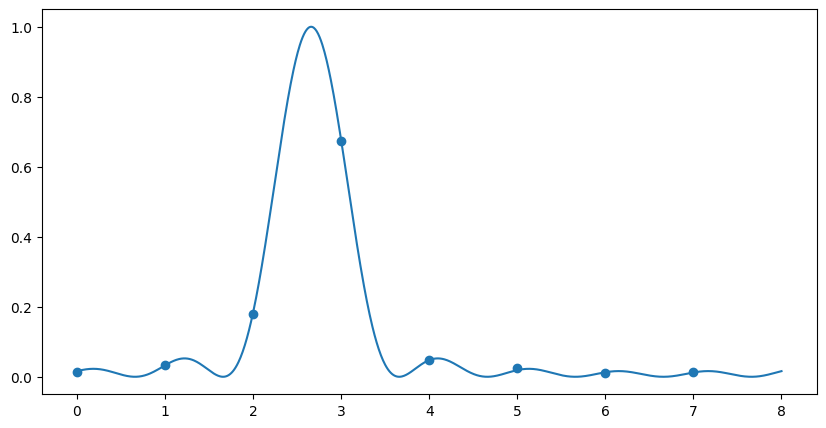

In [ ]:
recording_qubits = 3
total_shots = 2048
counts, parsed_counts = get_counts(synthesize_from_phase(theta = 2*pi/3, recording_qubits=recording_qubits))
y, shots = process_parsed_counts(parsed_counts)
y_guess = y[np.where(shots == max(shots))][0]
#y_guess = np.sum(y * shots)/total_shots
prob = (1/total_shots) * np.array(shots)
generate_histogram(y, prob)
parameters, pcov = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess)
print(parameters, pcov)

[0.33332205] [[1.94581879e-11]]


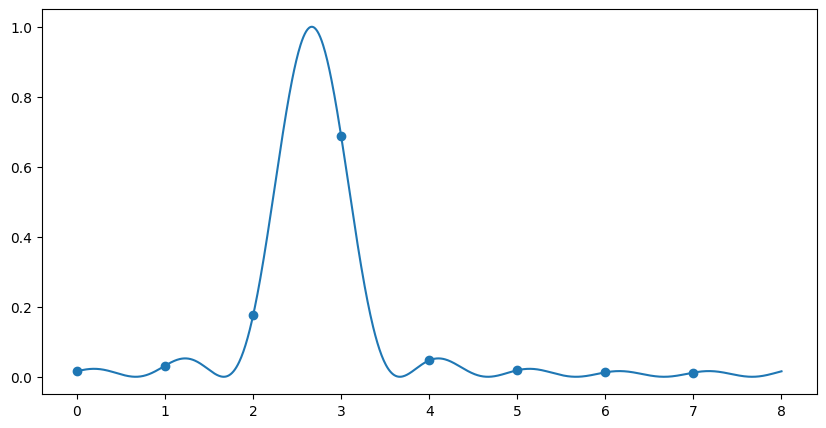

In [23]:
recording_qubits = 3
num_shots = 10000000
counts, parsed_counts = get_counts(synthesize_from_phase(theta = 2*pi/3, recording_qubits=recording_qubits, num_shots=num_shots))
y, shots = process_parsed_counts(parsed_counts)
y_guess = y[np.where(shots == max(shots))][0]
#y_guess = np.sum(y * shots)/total_shots
prob = (1/num_shots) * np.array(shots)
generate_histogram(y, prob)
parameters, pcov = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess)
print(parameters, pcov)

In [24]:
recording_qubits = 3
num_shots = 100000000
counts, parsed_counts = get_counts(synthesize_from_phase(theta = 2*pi/3, recording_qubits=recording_qubits, num_shots=num_shots))
y, shots = process_parsed_counts(parsed_counts)
y_guess = y[np.where(shots == max(shots))][0]
#y_guess = np.sum(y * shots)/total_shots
prob = (1/num_shots) * np.array(shots)
generate_histogram(y, prob)
parameters, pcov = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess)
print(parameters, pcov)

ClassiqAPIError: Error number 90000 occurred. Error number 200000 occurred. Please try again later.

Error identifier: E95C65042-E473-4BA6-9859-9243D9CFEE48.

Error identifier: E5EF3C5C9-0E76-40EC-9DF3-2F16199D3E03.
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack
If the error persists feel free to open a ticket at: https://short.classiq.io/support

[0.33333663] [[2.15118075e-12]]


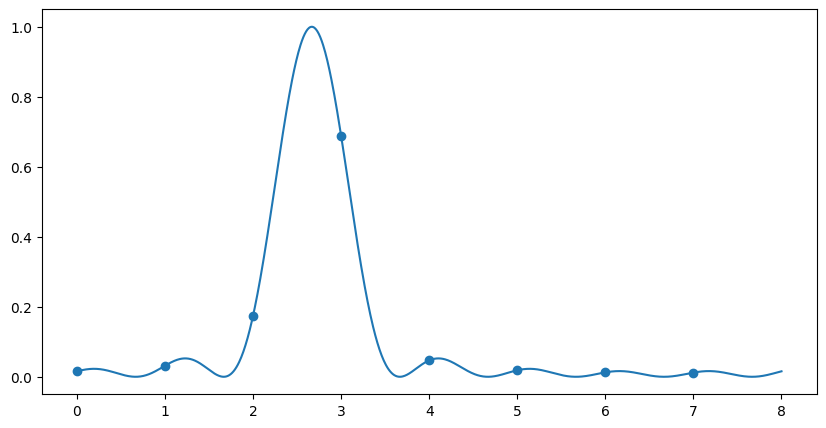

In [25]:
recording_qubits = 3
num_shots = 30000000
counts, parsed_counts = get_counts(synthesize_from_phase(theta = 2*pi/3, recording_qubits=recording_qubits, num_shots=num_shots))
y, shots = process_parsed_counts(parsed_counts)
y_guess = y[np.where(shots == max(shots))][0]
#y_guess = np.sum(y * shots)/total_shots
prob = (1/num_shots) * np.array(shots)
generate_histogram(y, prob)
parameters, pcov = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess)
print(parameters, pcov)

[0.33332956] [[7.16461639e-13]]


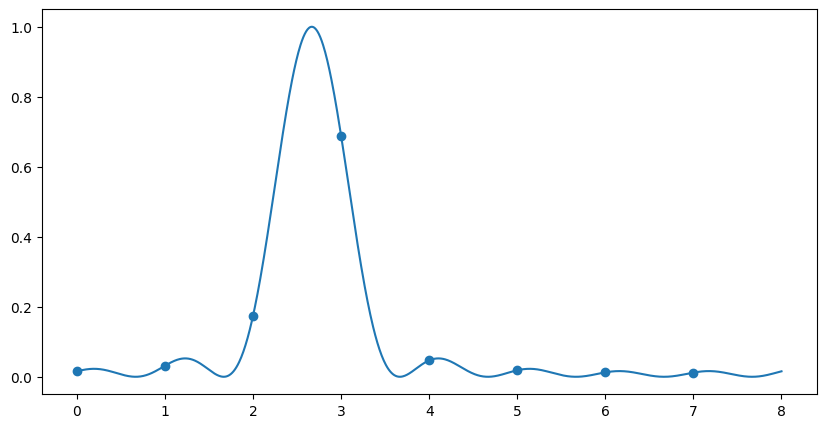

In [26]:
recording_qubits = 3
num_shots = 50000000
counts, parsed_counts = get_counts(synthesize_from_phase(theta = 2*pi/3, recording_qubits=recording_qubits, num_shots=num_shots))
y, shots = process_parsed_counts(parsed_counts)
y_guess = y[np.where(shots == max(shots))][0]
#y_guess = np.sum(y * shots)/total_shots
prob = (1/num_shots) * np.array(shots)
generate_histogram(y, prob)
parameters, pcov = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess)
print(parameters, pcov)

[0.33333658] [[8.95705177e-13]]


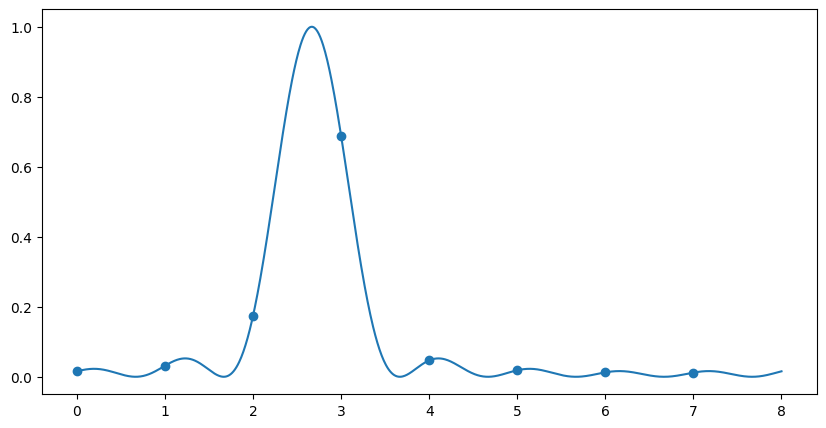

In [27]:
recording_qubits = 3
num_shots = 75000000
counts, parsed_counts = get_counts(synthesize_from_phase(theta = 2*pi/3, recording_qubits=recording_qubits, num_shots=num_shots))
y, shots = process_parsed_counts(parsed_counts)
y_guess = y[np.where(shots == max(shots))][0]
#y_guess = np.sum(y * shots)/total_shots
prob = (1/num_shots) * np.array(shots)
generate_histogram(y, prob)
parameters, pcov = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess)
print(parameters, pcov)

The initial y guesses are  [4. 3.] and the approximate values should be 4.0  and  2.6666666666666665
The guessed values are:  [0.5021     0.49452928 0.49353036 0.33320002] with covariance:  [[ 9.70906108e-05 -5.41440619e-05 -6.46317673e-05  6.08359332e-07]
 [-5.41440619e-05  5.39567421e-05  3.77439424e-05 -1.60607863e-06]
 [-6.46317673e-05  3.77439424e-05  4.65177430e-05 -3.34637210e-07]
 [ 6.08359332e-07 -1.60607863e-06 -3.34637210e-07  1.92325071e-07]]
The actual thetas are  0.5  and  0.3333333333333333


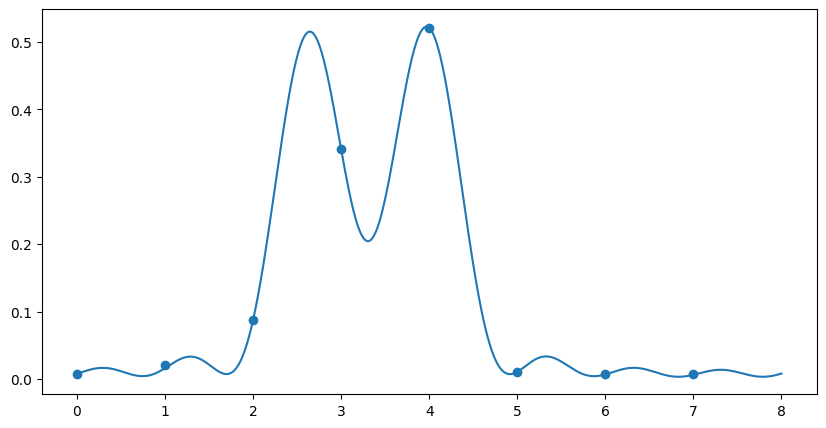

In [16]:
theta1 = 1/2
theta2 = 1/3
recording_qubits = 3
total_shots = 2048
matrix = [[np.exp(1j * 2*pi * theta1), 0],
          [0, np.exp(1j * 2*pi * theta2)]]
counts, parsed_counts = get_counts(synthesize_from_matrix(matrix=matrix, recording_qubits=recording_qubits))
y, shots = process_parsed_counts(parsed_counts)
prob = (1/total_shots) * np.array(shots)
generate_histogram(y, prob)
guesses = y[:2]
print("The initial y guesses are ", guesses, "and the approximate values should be", theta1*(2**recording_qubits), " and ", theta2*(2**recording_qubits))
parameters, pcov = multiple_fitting_curve_parameters(recording_qubits, y, prob, guesses = guesses)
print("The guessed values are: ", parameters, "with covariance: ", pcov) #parameters consists of [a0, a1, theta0, theta1]
print("The actual thetas are ", theta1, " and ", theta2)

## Accuracy and Complexity Tests

[0.31251502] [[0.00099627]]


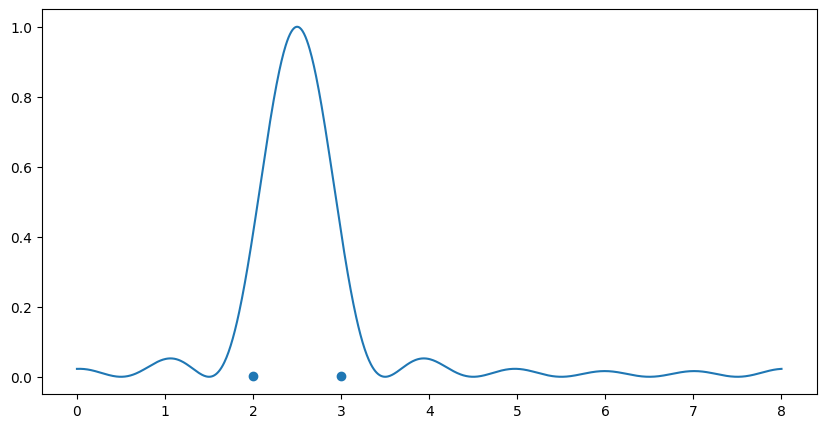

In [18]:
recording_qubits = 3
num_shots = 5
counts, parsed_counts = get_counts(synthesize_from_phase(theta = 2*pi/3, recording_qubits=recording_qubits, num_shots=num_shots))
y, shots = process_parsed_counts(parsed_counts)
y_guess = y[np.where(shots == max(shots))][0]
#y_guess = np.sum(y * shots)/total_shots
prob = (1/total_shots) * np.array(shots)
generate_histogram(y, prob)
parameters, pcov = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess)
print(parameters, pcov)

In [10]:

def get_parameters(quantum_program, num_shots):
    _, parsed_counts = get_counts(quantum_program)
    y, shots = process_parsed_counts(parsed_counts)
    y_guess = y[:1]
    prob = (1/num_shots) * np.array(shots)
    parameters, _ = fitting_curve_parameters(recording_qubits, y, prob, y_guess = y_guess, curve_plot=False)
    if parameters == False:
        return np.nan
    else:
        return parameters[0]


def sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits = 3, initial_i = 0):
    quantum_program = synthesize_from_phase(theta = 2*pi * phase, recording_qubits=recording_qubits)
    for num_shots in num_shots_list:
        print(num_shots)
        sum_squared_errors = 0
        
        circuit = GeneratedCircuit.from_qprog(quantum_program)
        width = circuit.data.width
        depth = circuit.transpiled_circuit.depth

        all_execution_preferences = [ExecutionPreferences(num_shots=num_shots, random_seed=i) for i in range(initial_i, initial_i + rounds)]
        all_qprogs = [set_quantum_program_execution_preferences(quantum_program, preferences) for preferences in all_execution_preferences]
        all_estimated_phases = np.array([get_parameters(qprog, num_shots) for qprog in all_qprogs])
        
        starting_i = initial_i + rounds
        while any(np.isnan(all_estimated_phases)):

            nan_indices = np.argwhere(np.isnan(all_estimated_phases))
            ending_i = starting_i + len(nan_indices)

            nan_execution_preferences = [ExecutionPreferences(num_shots=num_shots, random_seed=i) for i in range(starting_i, ending_i)]
            nan_qprogs = [set_quantum_program_execution_preferences(quantum_program, preferences) for preferences in nan_execution_preferences]
            
            nan_estimated_phases = [get_parameters(qprog, num_shots) for qprog in nan_qprogs]
            iter_nan_estimated_phases = iter(nan_estimated_phases)
            all_estimated_phases = np.array([next(iter_nan_estimated_phases) if np.isnan(x) else x for x in all_estimated_phases])
            starting_i = ending_i

        all_errors = all_estimated_phases - phase
        sum_squared_errors = sum(all_errors **2)

        row = [sum_squared_errors, num_shots, phase, recording_qubits, rounds, width, depth]
        with open('data.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(row)
    return True

In [178]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000]
print(num_shots_list)
rounds = 50
phase = 1/3
recording_qubits = 3
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000]
10
[0.42201879 0.32446686 0.32006171 0.33863713 0.4207383  0.30865023
 0.34208379 0.32783717 0.34998008 0.42210429 0.40768984 0.41389309
 0.31645386 0.41389309 0.33286182 0.3292617  0.3327189  0.41713818
 0.4220554  0.33286182 0.32012364 0.40791621 0.40786489 0.31643218
 0.34231016 0.327944   0.33863713 0.41634736 0.34208379 0.33863713
 0.32795251 0.33863713 0.40001992 0.33117223 0.33638861 0.35150702
 0.34231016 0.3361515  0.34998008 0.3327189  0.33863713 0.3327189
 0.3327189  0.42650124 0.42637545 0.34231016 0.34208379 0.31609416
 0.4220113  0.41887319]
20
[0.41356391 0.32406078 0.32226852 0.3347057  0.40945156 0.31817238
 0.34412288 0.33366024 0.39810073 0.33734655 0.33746624 0.3336584
 0.33111454 0.40587711 0.34240092 0.34392863 0.33213362 0.40786489
 0.4179798  0.34054844 0.33293118 0.33924297 0.31854279 0.3285963
 0.33565394 0.32958134 0.33457952 0.32971974 0.33623815 0.41095501
 0.33742833 0.337428

KeyboardInterrupt: 

Values I want to test

standard num_shots list: [100, 1000, 10000, 100000, 1000000, 10000000]

phases: 1/3, 1/5, 1/7, 1/9

recording qubits: 2, 3, 4, 5, 6, 7, 8, 9, 10

In [43]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]  #100, 1000, 10000, 100000, 1000000, 10000000, 30000000, #200, 400, 600, 800, 2000, 4000, 6000, 8000
print(num_shots_list)
rounds = 10
phase = 1/3
recording_qubits = 3
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[75000000]
75000000


True

In [46]:
num_shots_list = [100, 1000, 10000, 100000, 1000000, 10000000] #, 30000000, 50000000, 75000000]   
print(num_shots_list)
rounds = 30
phase = 1/9
recording_qubits = 3
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[100, 1000, 10000, 100000, 1000000, 10000000]
100
1000


Task exception was never retrieved
future: <Task finished name='Task-3632' coro=<execute_async() done, defined at /Users/syralie/Desktop/QCourse551-1/qcourse/lib/python3.11/site-packages/classiq/executor.py:50> exception=ReadTimeout('')>
Traceback (most recent call last):
  File "/Users/syralie/Desktop/QCourse551-1/qcourse/lib/python3.11/site-packages/anyio/streams/tls.py", line 133, in _call_sslobject_method
    result = func(*args)
             ^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/ssl.py", line 921, in read
    v = self._sslobj.read(len)
        ^^^^^^^^^^^^^^^^^^^^^^
ssl.SSLWantReadError: The operation did not complete (read) (_ssl.c:2580)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/syralie/Desktop/QCourse551-1/qcourse/lib/python3.11/site-packages/anyio/_core/_tasks.py", line 115, in fail_after
    yield cancel_scope
  File "/Use

10000
100000
1000000
10000000


True

## Separator

In [14]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 2
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits, initial_i = 0)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [15]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 2
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [16]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 2
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [17]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 2
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

## Separator

In [18]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 3
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [19]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]  
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 3
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [20]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 3
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [21]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]   
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 3
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

## Separator

In [22]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 4
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [23]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 4
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [24]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 4
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [25]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 4
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

## Separator

In [26]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] #10, 20, 30, 
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 5
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [27]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 5
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [28]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]  
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 5
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [29]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 5
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

## Separator

In [30]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]  
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 6
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [31]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]   
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 6
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [32]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 6
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [33]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 6
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

## Separator

In [34]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]  
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 7
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [35]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 7
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [36]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 7
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [37]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 7
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

## Separator

In [44]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000]  #200, 400, 600, 800, 2000, 4000, 6000, 8000
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 8
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [45]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 8
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000]
200
400
600
800
2000
4000
6000
8000


True

In [38]:
num_shots_list = [200, 400, 600, 800, 2000, 4000, 6000, 8000, 10000000] 
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 8
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[200, 400, 600, 800, 2000, 4000, 6000, 8000, 10000000]
200
400
600
800
2000
4000
6000
8000
10000000


True

In [39]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 8
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000]
10
20
30
40
50
60
70
80
90
100
1000
10000
100000
1000000
10000000
200
400
600
800
2000
4000
6000
8000


True

## Separator

In [40]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 9
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000]
10


/Users/syralie/Desktop/QCourse551-1/qcourse/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


No optimal parameters found
20
30
40
50
60
70
80
90
100
1000
10000
100000
1000000
10000000


/var/folders/jm/5_vb8qrd4wg650hn5xbtrz1h0000gn/T/ipykernel_24278/1789590579.py:10: RuntimeWarning: divide by zero encountered in divide
  prob_y = coeff * numerator/denominator


200
400


ReadTimeout: 

In [ ]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 9
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[100, 1000, 10000, 100000, 1000000, 10000000]
100
1000
10000
100000
1000000
10000000


True

In [ ]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 9
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[100, 1000, 10000, 100000, 1000000, 10000000]
100
1000
10000
100000
1000000
10000000


True

In [ ]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 9
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[100, 1000, 10000, 100000, 1000000, 10000000]
100
1000
10000
100000
1000000
10000000


True

## Separator

In [ ]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/3
recording_qubits = 10
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[100, 1000, 10000, 100000, 1000000, 10000000]
100
1000
10000
100000
1000000
10000000


True

In [ ]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/5
recording_qubits = 10
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[100, 1000, 10000, 100000, 1000000, 10000000]
100
1000
10000
100000
1000000
10000000


True

In [ ]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000]  
print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 10
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[100, 1000, 10000, 100000, 1000000, 10000000]
100
1000
10000
100000
1000000
10000000


True

In [ ]:
num_shots_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000, 10000, 100000, 1000000, 10000000, 200, 400, 600, 800, 2000, 4000, 6000, 8000] 
print(num_shots_list)
rounds = 100
phase = 1/9
recording_qubits = 10
sumSE_across_num_shots(num_shots_list, rounds, phase, recording_qubits)

[100, 1000, 10000, 100000, 1000000, 10000000]
100
1000
10000
100000
1000000
10000000


True

In [39]:
import json
quantum_program = synthesize_from_phase(theta = 2*pi * (1/3), recording_qubits=2, num_shots=100)
def get_counts(quantum_program):
    job = execute(quantum_program) #job is like an id, can be used later
    results = job.result()
    return results[0].value.counts, results[0].value.parsed_counts

def process_parsed_counts(parsed_counts):
    y = []
    shots = []
    for item in parsed_counts:
        y.append(item.state['Phase'])
        shots.append(item.shots)
    return np.array(y), np.array(shots)

for _ in range(1):
    job = execute(quantum_program) #job is like an id, can be used later
    results = job.result()
    #print(results[0].value.counts)
    res = json.loads(quantum_program)
    print(res["model"]['functions'][0]['port_declarations']['Phase']['size'])
    #print(GeneratedCircuit.parse_raw(quantum_program).SynthesisQuantumFunctionCall.function_params.size)
    print(GeneratedCircuit.parse_raw(quantum_program).model.functions[0].port_declarations['Phase'].size)
    print(GeneratedCircuit.parse_raw(quantum_program).model.functions[0].body[1].function_params.size)
    print(GeneratedCircuit.parse_raw(quantum_program).model.execution_preferences.num_shots)
    #print(GeneratedCircuit.parse_raw(quantum_program).model.execution_preferences.random_seed)
    #print(type(res))
    #print(res['model']['execution_preferences']['random_seed'])
    #print(res['model']['execution_preferences']['num_shots'])
    #print(quantum_program["model"])
    #_, parsed_counts = get_counts(quantum_program)
    #y, shots = process_parsed_counts(parsed_counts)
    #print(y, shots)

2
2
2
100


In [46]:
num_shots = 1000
#print(num_shots_list)
rounds = 100
phase = 1/7
recording_qubits = 10
quantum_program = synthesize_from_phase(theta = 2*pi * phase, recording_qubits=recording_qubits, num_shots=num_shots)
print(GeneratedCircuit.parse_raw(quantum_program).model.functions[0].body[1].function_params.size)
print(GeneratedCircuit.parse_raw(quantum_program).model.execution_preferences.num_shots)
Curve_Fitted_QPE(quantum_program)

10
1000


0.14287094971829645

### Ratio data generation
